# Importing libraries

In [1]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limit TensorFlow to only use first GPU, and grow memory as needed
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ TensorFlow is using GPU:", gpus[0])
    except RuntimeError as e:
        print("⚠️ GPU setup failed:", e)
else:
    print("❌ No GPU found, running on CPU.")

✅ TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
dataset_path= r'D:\Medicinal_Plant_Identification\Dataset'

In [4]:
import os
import cv2
import numpy as np

def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))  # keep class order consistent
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    # Iterate through class directories
    for class_dir in class_names:
        class_path = os.path.join(dataset_path, class_dir)
        if not os.path.isdir(class_path):  # skip non-folder files
            continue
        class_label = class_to_idx[class_dir]

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # skip unreadable files
                image = cv2.resize(image, image_size)
                image = image.astype(np.float32) / 255.0  # normalize
                images.append(image)
                labels.append(class_label)
            except Exception as e:
                print(f"⚠️ Error loading {image_path}: {e}")

    return np.array(images), np.array(labels), class_names


# **Transfer Learning with MobileNet Model**

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the data will be used for testing
    subset="training",     # Specify "training" to get the training subset
    seed=42,
    label_mode='int'
)
num_examples = data.cardinality().numpy()
num_classes = len(data.class_names)

# Split the data into training and testing
testing_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # No validation split for testing
    seed=42,
    label_mode='int',
    subset="validation"    # Specify "validation" to get the testing subset
)

Found 5617 files belonging to 22 classes.
Using 4494 files for training.
Found 5617 files belonging to 22 classes.
Using 1123 files for validation.


# Training Model

In [6]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label
train_data = data
# Define the validation split ratio
validation_split = 0.2
num_validation_samples = int(num_examples * validation_split)
validation_data = data.take(num_validation_samples)

train_batches = train_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Create the final model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_batches, validation_data=validation_batches, epochs=10)

# Evaluate the model on the testing dataset
testing_batches = testing_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(testing_batches)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

Epoch 1/10
141/141 [==============================] - 47s 222ms/step - loss: 1.0609 - accuracy: 0.6983 - val_loss: 0.4503 - val_accuracy: 0.8917
Epoch 2/10
141/141 [==============================] - 15s 109ms/step - loss: 0.3313 - accuracy: 0.9201 - val_loss: 0.2603 - val_accuracy: 0.9386
Epoch 3/10
141/141 [==============================] - 15s 106ms/step - loss: 0.2081 - accuracy: 0.9539 - val_loss: 0.1843 - val_accuracy: 0.9621
Epoch 4/10
141/141 [==============================] - 15s 106ms/step - loss: 0.1491 - accuracy: 0.9724 - val_loss: 0.1412 - val_accuracy: 0.9721
Epoch 5/10
141/141 [==============================] - 15s 106ms/step - loss: 0.1137 - accuracy: 0.9811 - val_loss: 0.1124 - val_accuracy: 0.9799
Epoch 6/10
141/141 [==============================] - 15s 106ms/step - loss: 0.0899 - accuracy: 0.9882 - val_loss: 0.0916 - val_accuracy: 0.9833
Epoch 7/10
141/141 [==============================] - 15s 106ms/step - loss: 0.0728 - accuracy: 0.9933 - val_loss: 0.0760 - val_ac

# Model's Description

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 22)                28182     
                                                                 
Total params: 2,286,166
Trainable params: 28,182
Non-trainable params: 2,257,984
_________________________________________________________________


# Plot for training and validation

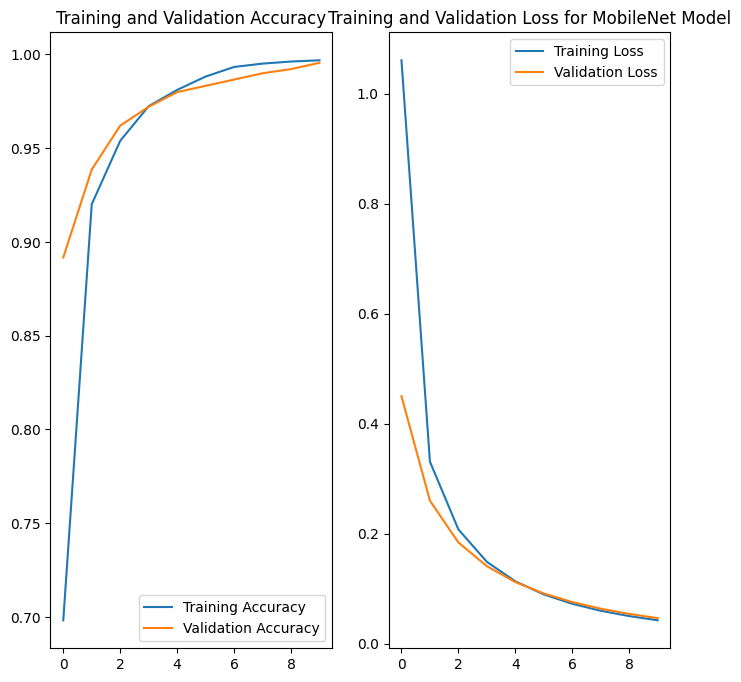

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Define epoch range
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet Model')

plt.show()


In [10]:
import tensorflow as tf
# Suppress TensorFlow warnings
tf.get_logger().setLevel("ERROR")
# Save the trained model to a file
model.save("Model_Mobilenet_pl.h5")

# **Prediction**

In [ ]:
input_image_path = r'D:\Medicinal_Plant_Identification\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset\Amla\364.jpg'
input_image = load_img(input_image_path, target_size=(224, 224))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Medicinal_Plant_Identification\\Indian Medicinal Leaves Image Datasets\\Medicinal Leaf dataset\\Amla\\364.jpg'

1/1 [==============================] - 0s 26ms/step


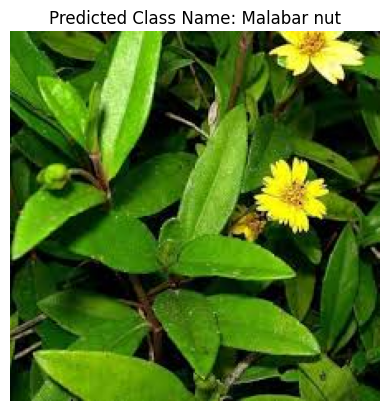

In [34]:
input_image_path = r'brin.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

In [21]:
print(data.class_names)

['Aloevera', 'Amla', 'Amruthaballi', 'Arjun tree', 'Betel', 'Bitter vine', 'Bringaraja', 'Cathedral Bells', 'Coriender', 'Crown flower', 'Curry', 'Ginger', 'Goose berry', 'Gotu kola', 'Hibiscus', 'Lemon', 'Malabar nut', 'Mint', 'Neem', 'Pomoegranate', 'Tulsi', 'Turmeric']
